# White particles

I received a new image from Qiaoge, with the majority of particles white. See below:

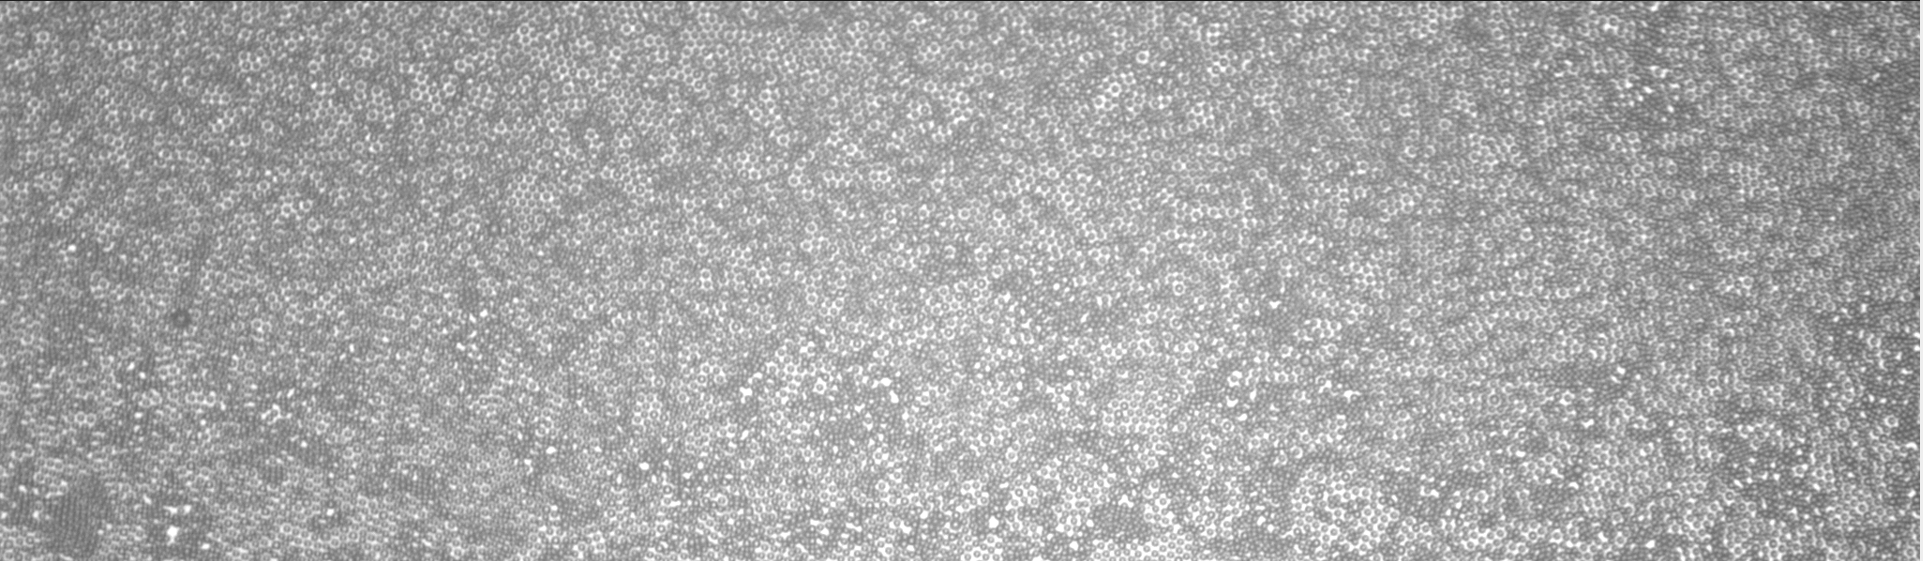

In [16]:
from skimage import io
import matplotlib.pyplot as plt
import numpy as np
from myimagelib.myImageLib import to8bit, matlab_style_gauss2D, bestcolor
from scipy.signal import convolve2d
from myimagelib.xcorr_funcs import normxcorr2, FastPeakFind
import pandas as pd
from skimage.feature import peak_local_max
from skimage import io, measure, draw
from bwtrack.bwtrack import *
from matplotlib.collections import PatchCollection

## 1 The old method

We can start by using the old `find_white()` function and see what is the problem. 

In [12]:
def find_white(img, size=7, thres=None, std_thres=None, plot_hist=False):
    """
    Similar to find_black.
    """
    
    img = to8bit(img) # convert to 8-bit and saturate
    
    mh = mexican_hat(shape=(5,5), sigma=0.8) # 这里shape和上面同理，sigma需要自行尝试一下，1左右
    #plt.imshow(mh, cmap="gray")

    corr = normxcorr2(mh, img, "same")
    coordinates = peak_local_max(corr, min_distance=5) 
    
    # apply min_dist criterion
    particles = pd.DataFrame({"x": coordinates.T[1], "y": coordinates.T[0]})
    # 加入corr map峰值，为后续去重合服务
    particles["peak"] = corr[particles.y, particles.x]
    particles = min_dist_criterion(particles, size)
    
    # 计算mask内的像素值的均值和标准差
    ## Create mask with feature regions as 1
    R = size / 2.
    mask = np.zeros(img.shape)
    for num, i in particles.iterrows():
        rr, cc = draw.disk((i.y, i.x), 0.8*R) # 0.8 to avoid overlap
        mask[rr, cc] = 1

    ## generate labeled image and construct regionprops
    label_img = measure.label(mask)
    regions = measure.regionprops_table(label_img, intensity_image=img, properties=("label", "centroid", "intensity_mean", "image_intensity")) # use raw image for computing properties
    table = pd.DataFrame(regions)
    table["stdev"] = table["image_intensity"].map(np.std)
    
    ## Arbitrary lower bound here, be careful!
    intensity_lb = (table["intensity_mean"].median() + table["intensity_mean"].mean()) / 4
    table = table.loc[table["intensity_mean"]>=intensity_lb]
    
    if thres is not None and std_thres is not None:
        table = table.loc[(table["intensity_mean"] <= thres)&(table["stdev"] <= std_thres)]
    elif thres is None and std_thres is None:
        print("Threshold value(s) are missing, all detected features are returned.")        
    elif thres is not None and std_thres is None:
        print("Standard deviation threshold is not set, only apply mean intensity threshold")
        table = table.loc[table["intensity_mean"] <= thres]
    elif thres is None and std_thres is not None:
        print("Mean intensity threshold is not set, only apply standard deviation threshold")
        table = table.loc[table["stdev"] <= std_thres]
    
    if plot_hist == True:
        table.hist(column=["intensity_mean", "stdev"], bins=20)
    
    table = table.rename(columns={"centroid-0": "y", "centroid-1": "x"}).drop(columns=["image_intensity"])

    return table

In [13]:
img = io.imread("large.tif")
particles = find_white(img, size=7)

C:\Users\liuzy\Documents\Github\mylib\src\myimagelib\xcorr_funcs.py:42: RuntimeWarning: divide by zero encountered in divide
  out = out / np.sqrt(image * template)


Threshold value(s) are missing, all detected features are returned.


In [14]:
particles

,label,y,x,intensity_mean,stdev
0,1,5.0,7.0,115.142857,45.822719
1,2,5.0,26.0,101.476190,38.996697
2,3,5.0,240.0,84.761905,34.328996
3,4,5.0,315.0,137.666667,53.905755
4,5,5.0,359.0,62.095238,23.977790
...,...,...,...,...,...
9910,9911,594.0,1904.0,82.952381,34.009081
9911,9912,594.0,1912.0,81.142857,32.451416
9912,9913,594.0,1936.0,109.095238,44.550089
9913,9914,594.0,1943.0,102.857143,42.108431


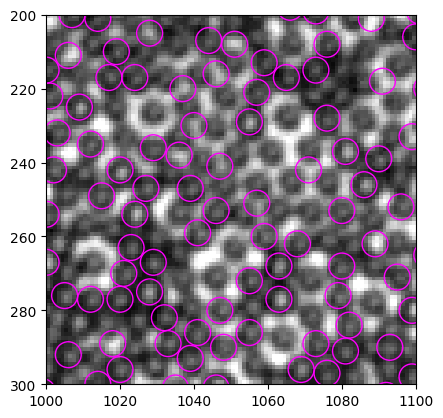

In [18]:
b_circ = [plt.Circle((xi, yi), radius=3.5, linewidth=1, fill=False, ec="magenta") for xi, yi in zip(particles.x, particles.y)]
b = PatchCollection(b_circ, match_original=True)
left, right, bottom, top = 1000, 1100, 300, 200
fig, ax = plt.subplots(dpi=100)
ax.imshow(img[top:bottom, left:right], cmap="gray", extent=(left, right, bottom, top))
ax.add_collection(b)

I have two general observations:
- only part of the particles are identified
- some bright "void" are identified as particles

These problems suggests that the mask we use to detect white particles - the Mexican hat shape - does not capture the characteristics of white particles well, and therefore leads to false positives and missing particles. We briefly discussed this issue before. Basically, Mexican hat shape describes an intensity profile that has a high peak in the center and a low ring in the intermediate distance, and a medium value in the long distance:

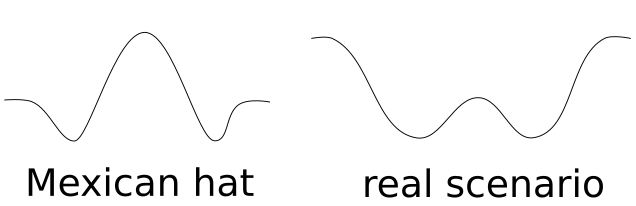

We can take a few example particles and study precisely the intensity profiles. (probably we can use a polynomial profile to fit)